In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2025-04-21 05:45:55.642799: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745214355.854484      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745214355.909044      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import warnings
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Flatten, Dense, Concatenate, GlobalAveragePooling2D, Multiply, Reshape, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, DenseNet121, ResNet101
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import shutil
import os
import requests
import zipfile
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

2025-04-21 08:12:26.341574: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745223146.566538      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745223146.627699      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Suppress warnings
warnings.filterwarnings("ignore")
mixed_precision.set_global_policy('mixed_float16')

In [4]:
# base_dir = "/kaggle/working/extracted_dataset/An India soyabean leaf dataset/Soyabean leaf/"
base_dir = "/kaggle/input/swedish_dataset"

In [5]:
# Get class names from the base directory

class_names = os.listdir(base_dir)

for class_name in class_names:
    class_path = os.path.join(base_dir, class_name)
    
    if os.path.isdir(class_path):
        print(class_name)
        subdirectories = os.listdir(class_path)
        
        for subdirectory in subdirectories:
            sub_path = os.path.join(class_path, subdirectory)
            
            if os.path.isdir(sub_path):
                print("  -",subdirectory)

Salix_aurita
Sorbus_intermedia
Salix_sinerea
Tilia
Sorbus_aucuparia
Salix_alba_Sericea
Ulmus_glabra
Populus
Fagus_silvatica
Populus_tremula
Alnus_incana
Acer
Betula_pubescens
Quercus
Ulmus_carpinifolia


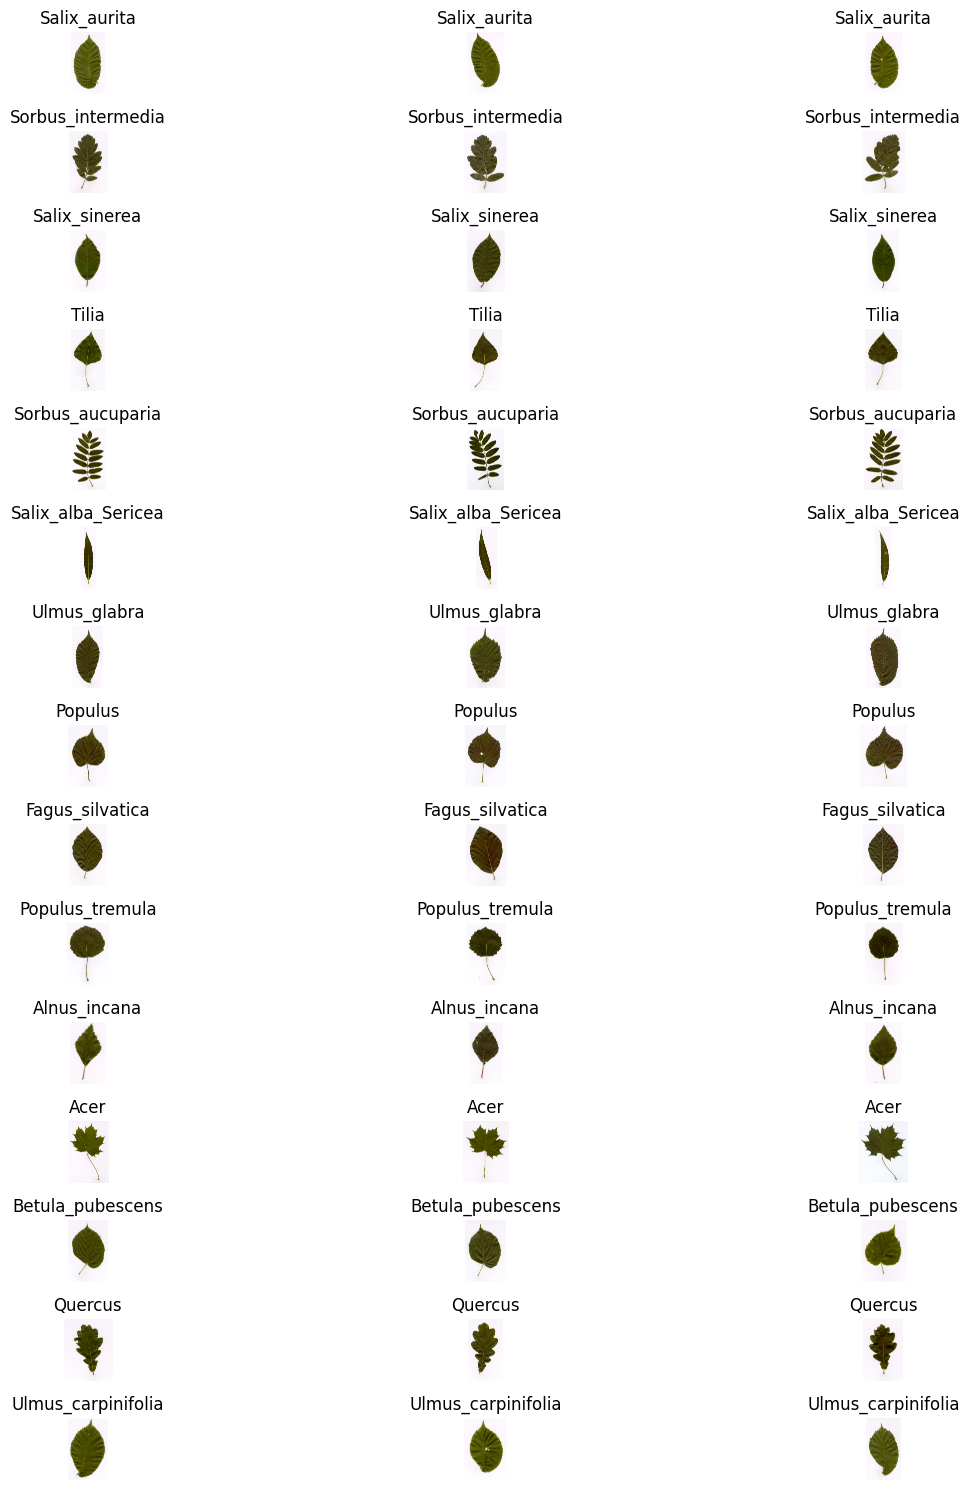

In [6]:
# Plot the images

def find_images(directory):
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif')):  
                image_files.append(os.path.join(root, file))
    return image_files

def plot_random_images(base_dir, class_names, num_images=3):
    
    plt.figure(figsize=(15, 15))
    for class_name in class_names:
        class_path = os.path.join(base_dir, class_name)
        
        if os.path.isdir(class_path):
            images = find_images(class_path)
            random_images = random.sample(images, min(num_images, len(images)))  
            
            for i, img_path in enumerate(random_images):
                img = plt.imread(img_path) 
                plt.subplot(len(class_names), num_images, class_names.index(class_name) * num_images + i + 1)
                plt.imshow(img)
                plt.axis('off')
                plt.title(class_name)
    plt.tight_layout()
    plt.show()

# Call the function to plot images
plot_random_images(base_dir, class_names, num_images=3)

In [7]:
input_dir = base_dir
output_dir = '/kaggle/working/swedish_dataset'

if not os.path.exists(output_dir):
    shutil.copytree(input_dir, output_dir)
    print("Files copied successfully.")

Files copied successfully.


In [8]:
for class_dir in os.listdir(output_dir):
    class_path = os.path.join(output_dir, class_dir)
    
    if os.path.isdir(class_path):
        for sub_dir in os.listdir(class_path):
            sub_path = os.path.join(class_path, sub_dir)
            
            if os.path.isdir(sub_path):
                for file in os.listdir(sub_path):
                    file_path = os.path.join(sub_path, file)
                    if os.path.isfile(file_path):  
                        shutil.move(file_path, class_path)                
                os.rmdir(sub_path)

print("Flattening completed. All files are now in their respective main class directories.")

Flattening completed. All files are now in their respective main class directories.


In [9]:
try:
    import splitfolders
except ImportError:
    !pip install split-folders
    try:
        import splitfolders
    except ImportError:
        print("Installation failed. Please check your environment and try again.")

splitfolders.ratio(output_dir, output='Image_dataset', seed=123, ratio=(0.7,0.2,0.1))

Copying files: 1125 files [00:10, 105.35 files/s]


In [11]:
output_dir = '/kaggle/working/swedish_dataset'

if os.path.exists(output_dir):
    shutil.rmtree(output_dir) 
    print(f"{output_dir} has been deleted.")
else:
    print(f"{output_dir} does not exist.")

/kaggle/working/swedish_dataset does not exist.


In [12]:
# Hyperparameters
batch_size = 64
input_shape = (224, 224, 3)
learning_rate = 1e-5 

In [13]:
# Data augmentation for the training set only
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=20,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Test set without data augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

# Training set
train_set = train_datagen.flow_from_directory(
    "/kaggle/working/Image_dataset/train",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

# Validation set
valid_set = test_datagen.flow_from_directory(
    "/kaggle/working/Image_dataset/val",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

# Testing set
test_set = test_datagen.flow_from_directory(
    "/kaggle/working/Image_dataset/test",  
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False 
)


Found 780 images belonging to 15 classes.
Found 225 images belonging to 15 classes.
Found 120 images belonging to 15 classes.


In [14]:
# Define the Model Architecture
input_layer = Input(shape=input_shape)
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
resnet_model = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)

I0000 00:00:1745223353.755073      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [15]:
def extract_features_with_reduction(model, inputs):
    features = model(inputs)
    features = GlobalAveragePooling2D()(features)
    features = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(features) 
    return features

In [16]:
# Extract and apply attention for each model
vgg_features = extract_features_with_reduction(vgg_model, input_layer)
densenet_features = extract_features_with_reduction(densenet_model, input_layer)
resnet_features = extract_features_with_reduction(resnet_model, input_layer)

In [17]:
# Feature extraction

# vgg_features = Flatten()(vgg_model(input_layer))
# densenet_features = GlobalAveragePooling2D()(densenet_model(input_layer))
# resnet_features = GlobalAveragePooling2D()(resnet_model(input_layer))

In [18]:
# Feature fusion or Concatenate features 
concatenated_features = Concatenate(axis=-1)([vgg_features, densenet_features, resnet_features])
reduced_features = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(concatenated_features)
reduced_features = BatchNormalization()(reduced_features)
reduced_features = Dropout(0.5)(reduced_features)

In [19]:
# Attention Mechanism
def attention_block(inputs):
    x = GlobalAveragePooling2D()(inputs)
    x = Dense(x.shape[-1], activation='relu')(x)
    x = Dense(x.shape[-1], activation='sigmoid')(x)
    return Multiply()([inputs, x])

attention_features = attention_block(Reshape((1, 1, reduced_features.shape[-1]))(reduced_features))
attention_features = Flatten()(attention_features)

In [20]:
# Fully Connected Layers (FC layer)
fc = Dense(512, activation='relu')(attention_features)
fc = Dropout(0.5)(fc) 
fc = Dense(256, activation='relu')(fc)
fc = Dropout(0.5)(fc)

In [21]:
# Output layer
output_layer = Dense(train_set.num_classes, activation='softmax', dtype='float32')(fc)

In [22]:
# Compile Model 

final_model = Model(inputs=input_layer, outputs=output_layer)
optimizer = Adam(learning_rate=learning_rate)

final_model.compile(
    loss='categorical_crossentropy', 
    optimizer=optimizer, 
    metrics=['accuracy']
)

In [23]:
# Callbacks for training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

In [24]:
# Summary of Model
final_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 7, 7, 512)      │     14,714,688 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ densenet121 (Functional)  │ (None, 7, 7, 1024)     │      7,037,504 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet101 (Functional)    │ (None, 7, 7, 2048)     │     42,658,176 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 512)            │              0 │ vgg16[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1024)           │              0 │ densenet121[0][0]      │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet101[0][0]        │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │        262,656 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 512)            │        524,800 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 512)            │      1,049,088 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 1536)           │              0 │ dense[0][0],           │
│                           │                        │                │ dense_1[0][0],         │
│                           │                        │                │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1024)           │      1,573,888 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 1024)           │          4,096 │ dense_3[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 1024)           │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 1024)     │              0 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1024)           │              0 │ reshape[0][0]          │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├──────────────────────

 Total params: 70,584,079 (269.26 MB)

 Trainable params: 70,393,039 (268.53 MB)

 Non-trainable params: 191,040 (746.25 KB)

In [25]:
# Train Model
history = final_model.fit(
    train_set,
    validation_data=valid_set,
    epochs=80,
    batch_size=batch_size,
    callbacks=[reduce_lr, model_checkpoint]
)

Epoch 1/80


I0000 00:00:1745223613.815827     123 service.cc:148] XLA service 0x7d8070003ce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745223613.816750     123 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745223637.468100     123 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745223890.007266     123 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/13 ━━━━━━━━━━━━━━━━━━━━ 790s 25s/step - accuracy: 0.1001 - loss: 35.6729 - val_accuracy: 0.0711 - val_loss: 35.0618 - learning_rate: 1.0000e-05
Epoch 2/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.0643 - loss: 35.5747 - val_accuracy: 0.0667 - val_loss: 34.9752 - learning_rate: 1.0000e-05
Epoch 3/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.0739 - loss: 35.4979 - val_accuracy: 0.0667 - val_loss: 34.9016 - learning_rate: 1.0000e-05
Epoch 4/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.0870 - loss: 35.2197 - val_accuracy: 0.0844 - val_loss: 34.8088 - learning_rate: 1.0000e-05
Epoch 5/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.0798 - loss: 35.0925 - val_accuracy: 0.0889 - val_loss: 34.7148 - learning_rate: 1.0000e-05
Epoch 6/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.1178 - loss: 34.9499 - val_accuracy: 0.0844 - val_loss: 34.6222 - learning_rate: 1.0000e-05
Epoch 7/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.1194 - lo

4/4 ━━━━━━━━━━━━━━━━━━━━ 50s 8s/step 
Classification Report:
                    precision    recall  f1-score   support

              Acer       0.33      0.33      0.33        15
      Alnus_incana       0.13      0.13      0.13        15
  Betula_pubescens       0.07      0.07      0.07        15
   Fagus_silvatica       0.13      0.13      0.13        15
           Populus       0.07      0.07      0.07        15
   Populus_tremula       0.13      0.13      0.13        15
           Quercus       0.07      0.07      0.07        15
Salix_alba_Sericea       0.00      0.00      0.00        15
      Salix_aurita       0.14      0.13      0.14        15
     Salix_sinerea       0.00      0.00      0.00        15
  Sorbus_aucuparia       0.00      0.00      0.00        15
 Sorbus_intermedia       0.07      0.07      0.07        15
             Tilia       0.20      0.20      0.20        15
Ulmus_carpinifolia       0.19      0.20      0.19        15
      Ulmus_glabra       0.13      0.1

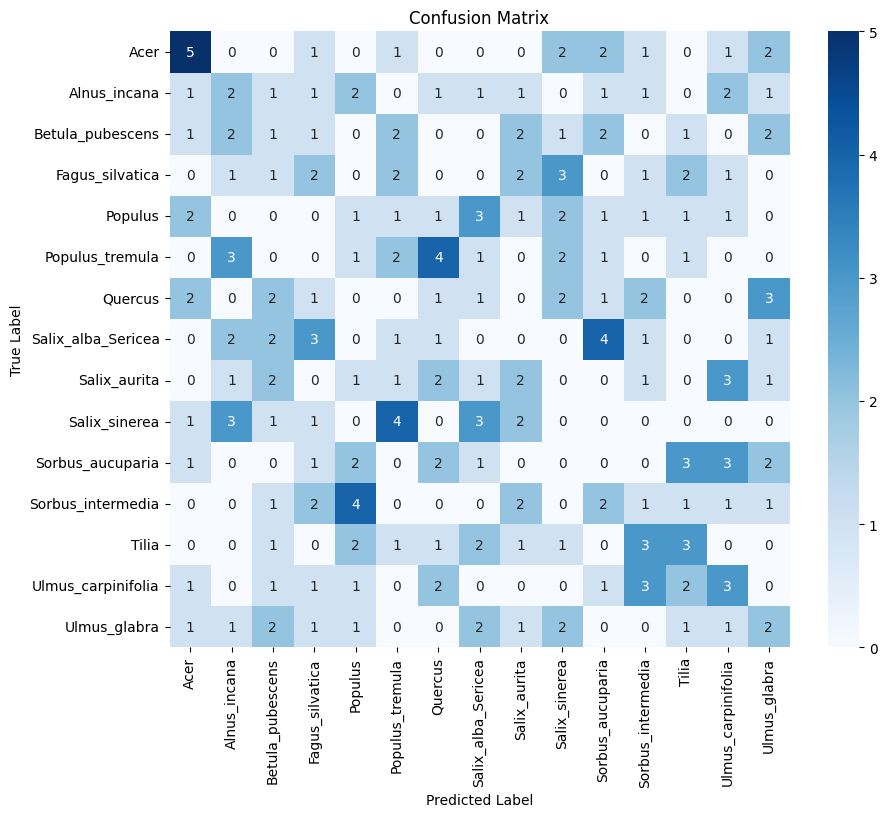

In [26]:
# Evaluate the model on the validation set
val_labels = valid_set.classes  # True labels
val_predictions = final_model.predict(valid_set)
val_pred_classes = np.argmax(val_predictions, axis=1)  # Predicted labels

# Calculate and print classification report
print("Classification Report:")
print(classification_report(val_labels, val_pred_classes, target_names=list(valid_set.class_indices.keys())))

# Confusion Matrix
conf_matrix = confusion_matrix(val_labels, val_pred_classes)

# Plotting Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=valid_set.class_indices.keys(), yticklabels=valid_set.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [26]:
# # Load the best model
# final_model.load_weights('best_model.keras')

In [27]:
# # Save the final model
# model_path = '/kaggle/working/my_model.keras' 
# final_model.save(model_path)
# print(f"Final model saved at {model_path}")

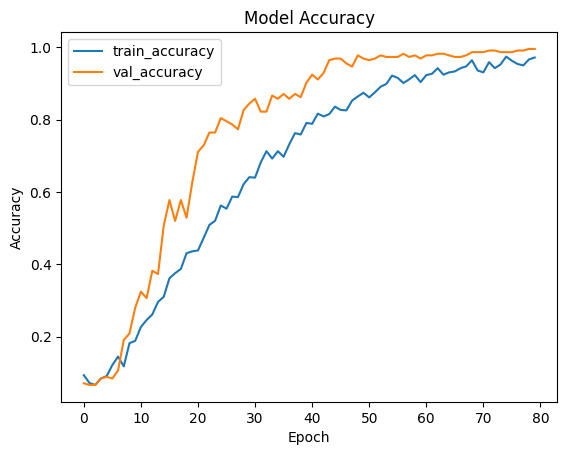

In [33]:
# Plot Training and Validation Accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

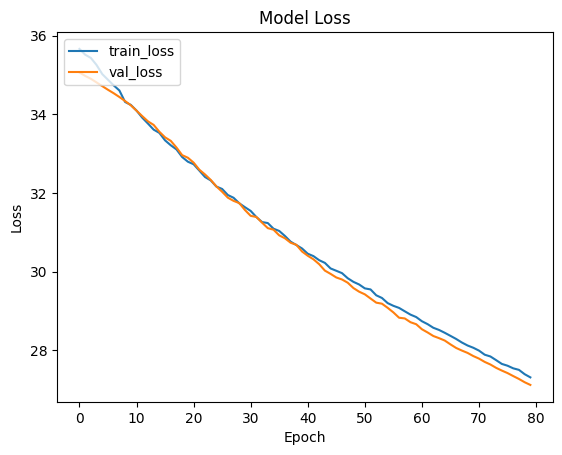

In [34]:
# Plot Training and Validation Loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [35]:
# # Load the model
# model_path = '/kaggle/working/my_model.keras'
# final_model = load_model(model_path)
# print("Model loaded successfully.")

In [36]:
test_loss, test_accuracy = final_model.evaluate(test_set)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step - accuracy: 0.9944 - loss: 27.1284
Test Loss: 27.132917404174805
Test Accuracy: 0.9916666746139526


In [37]:
predictions = final_model.predict(test_set)
predicted_classes = np.round(predictions).astype(int)  
print("Predicted Classes:", predicted_classes.flatten())

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
Predicted Classes: [1 0 0 ... 0 0 1]


In [38]:
# Function to predict image class
def predict_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=input_shape[:2])
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = tf.expand_dims(img_array, axis=0)
    predictions = final_model.predict(img_array)
    predicted_class = tf.argmax(predictions[0]).numpy()
    predicted_label = total_classes[predicted_class]
    return predicted_label